In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import cvxpy as cp  #pip install cvxpy --upgrade
import yfinance as yf


In [3]:
#%% Multi-asset analysis
#Calculate returns of individual stocks
tickers=['AAPL','AMZN','BAC','GE','MSFT','TSLA','NFLX']
#tickers=['AMZN']

df=pd.DataFrame()
for t in tickers:
    try:
        df[t]=yf.download(t, start='2010-01-01')['Adj Close']
    except:
        df[t] = ""
df.head(5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,AMZN,BAC,GE,MSFT,TSLA,NFLX
Date,,,,,,,
2009-12-31,6.471691,134.520004,13.059854,10.757807,23.630186,NaN,7.870000
2010-01-04,6.572422,133.899994,13.606186,10.985333,23.994564,NaN,7.640000
2010-01-05,6.583784,134.690002,14.048450,11.042215,24.002319,NaN,7.358571
2010-01-06,6.479061,132.250000,14.213213,10.985333,23.855013,NaN,7.617143
2010-01-07,6.467082,130.000000,14.681499,11.554157,23.606922,NaN,7.485714


AAPL      6.471691
AMZN    134.520004
BAC      13.059854
GE       10.757807
MSFT     23.630186
TSLA           NaN
NFLX      7.870000
Name: 2009-12-31 00:00:00, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

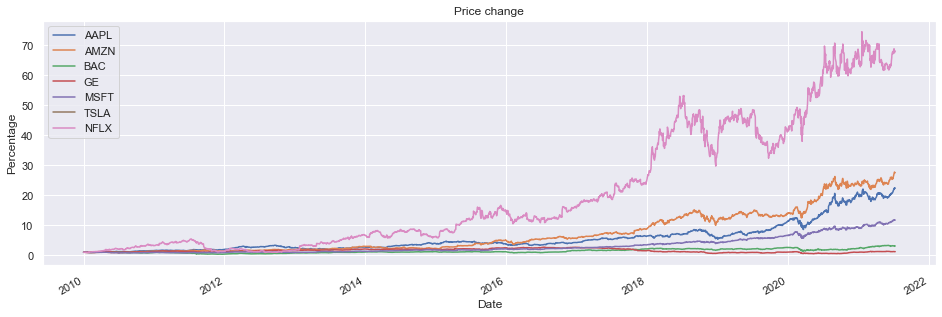

In [4]:
print(df.iloc[0])
(df/df.iloc[0]).plot(figsize=(16,5))
plt.title('Price change')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.show

                AAPL      AMZN       BAC        GE      MSFT      TSLA  \
Date                                                                     
2021-07-06  0.014718  0.046927 -0.026245 -0.032934  0.000036 -0.028458   
2021-07-07  0.017955  0.005670 -0.007986  0.004644  0.008175 -0.022636   
2021-07-08 -0.009200  0.009422 -0.024403 -0.008475 -0.008966  0.012658   
2021-07-09  0.013055 -0.003235  0.032491  0.022533  0.001874  0.006342   
2021-07-12 -0.001206 -0.005305  0.013611 -0.013678 -0.003418  0.039271   

                NFLX  
Date                  
2021-07-06  0.014345  
2021-07-07 -0.010487  
2021-07-08 -0.009702  
2021-07-09  0.009835  
2021-07-12 -0.000594  
AAPL    0.301627
AMZN    0.365970
BAC     0.166555
GE      0.069902
MSFT    0.276744
TSLA    0.604294
NFLX    0.441606
dtype: float64


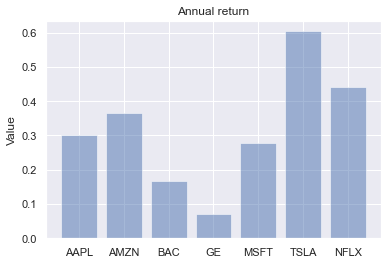

In [5]:
returns=(df/df.shift(1))-1
returns= returns.dropna()
print(returns.tail(5))
daily_returns=returns.mean()*250
print(daily_returns)

plt.bar(tickers,list(daily_returns),align='center',alpha=0.5)
plt.ylabel('Value')
plt.title('Annual return')
plt.show()

In [7]:
# train test split 70-30
T_trn = round(len(returns)*.7)
ret_mat = np.ascontiguousarray(returns.iloc[1::,:])
ret_trn = ret_mat[:T_trn,]
ret_tst = ret_mat[T_trn:,]

mu_trn = np.mean(ret_trn, axis=0) 
sigma_trn = np.cov(ret_trn.T)
# Equally weighted portfolio
w_EWP = np.ones(returns.shape[1])/returns.shape[1]
w_EWP

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

In [8]:
#%% Minimum variance portfolio:
# As investors are assumed risk-averse but still want to make a good profit
# we introduce the global minimum variance portfolio and the minimum variance portfolio with shortselling contraints

def GMVP(Sigma):
    ones = np.ones(Sigma.shape[0])
    Sigma_inv_1 = np.linalg.solve(Sigma, ones) # same as Sigma_inv @ ones
    w = Sigma_inv_1 / (np.sum(Sigma_inv_1))
    return w
w_GMVP = GMVP(sigma_trn)
print(w_GMVP)

# Minimum variance portfolio with short-selling
def MVP(mu, Sigma, cons ,w_EWP):
    w = cp.Variable(len(mu))
    variance = cp.quad_form(w, Sigma)
    expected_return = w @ mu
    if cons == "no short sell":
        constraint = [w @ mu >= w_EWP @ mu, w >= 0, cp.sum(w) == 1]
    if cons == "short sell":    
        constraint = [w @ mu >= w_EWP @ mu,cp.sum(w) == 1]
    problem = cp.Problem(cp.Minimize(variance), constraint)   
    problem.solve()         
    return w.value
w_MVP_short = MVP(mu_trn, sigma_trn,"short sell",w_EWP)
print(w_MVP_short)

[ 0.24137521  0.06568684 -0.05563966  0.42102685  0.29488733  0.0091625
  0.02350093]
[ 0.28598692  0.20012148 -0.0369077   0.06716281  0.3360221   0.06746075
  0.08015363]


In [9]:
#%% Maximum sharpe ratio portfolio
# This portfolio show the optimized return/risks ratios
def MSR(mu, Sigma):
    ones = np.ones(Sigma.shape[0])
    Sigma_inv_1 = np.linalg.solve(Sigma, mu) # same as Sigma_inv @ ones
    w = Sigma_inv_1 / (np.sum(Sigma_inv_1  ))
    return w
w_MSR = MSR(mu_trn, sigma_trn)
print(w_MSR)


[ 0.34992178  0.39278521 -0.01006216 -0.43997411  0.39497402  0.15101035
  0.16134492]


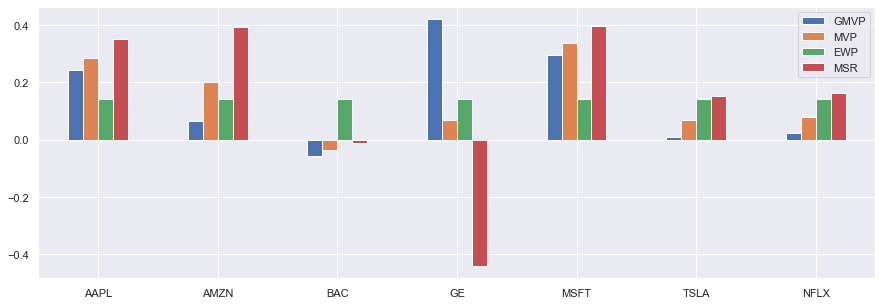

          AAPL      AMZN       BAC        GE      MSFT      TSLA      NFLX
GMVP  0.241375  0.065687 -0.055640  0.421027  0.294887  0.009162  0.023501
MVP   0.285987  0.200121 -0.036908  0.067163  0.336022  0.067461  0.080154
EWP   0.142857  0.142857  0.142857  0.142857  0.142857  0.142857  0.142857
MSR   0.349922  0.392785 -0.010062 -0.439974  0.394974  0.151010  0.161345


In [10]:
allocation = pd.DataFrame([w_GMVP,w_MVP_short,w_EWP,w_MSR],columns = tickers)
allocation.index = ['GMVP','MVP','EWP','MSR']
allocation.T.plot.bar(figsize = (15,5))
plt.xticks(rotation=0)
plt.show()

print(allocation)

In [11]:
def performance(returns,allocation):
    ret = []
    vol = []
    sharpe = []
    wealth = []
    for i in range(4):
        ret.append((np.array(returns) @ (allocation.iloc[i,:].T)).mean())
        vol.append(np.sqrt(np.dot(allocation.iloc[i,:],np.dot(returns.cov(),allocation.iloc[i,:].T))))
        sharpe.append(ret[i]/vol[i])
    performance = pd.DataFrame([ret,vol,sharpe],columns = allocation.index).T
    return performance

performance  = pd.concat([performance(returns.iloc[:T_trn,],allocation),
                         performance(returns.iloc[T_trn:,],allocation)], axis = 1)
performance.columns = ['avg excess return train','volatility train','sharpe ratio train',
                       'avg excess return test','volatility test','sharpe ratio test']
print(performance)

      avg excess return train  volatility train  sharpe ratio train  \
GMVP                 0.000722          0.010766            0.067027   
MVP                  0.001184          0.012082            0.097958   
EWP                  0.001180          0.013289            0.088786   
MSR                  0.001846          0.017143            0.107656   

      avg excess return test  volatility test  sharpe ratio test  
GMVP                0.001177         0.019339           0.060846  
MVP                 0.001601         0.018628           0.085950  
EWP                 0.001488         0.018557           0.080202  
MSR                 0.002209         0.026864           0.082240  


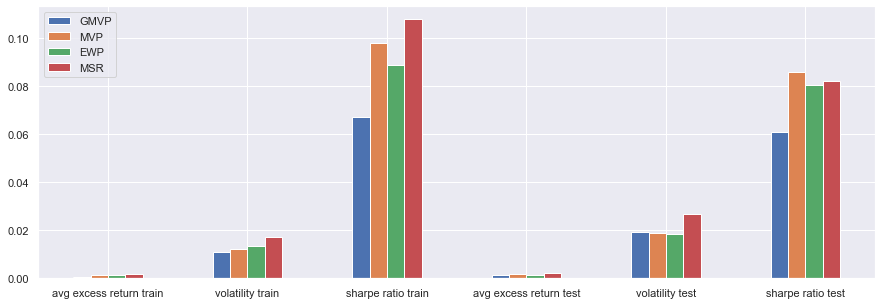

In [12]:
performance.T.plot.bar(figsize = (15,5))
plt.xticks(rotation=0)
plt.show()


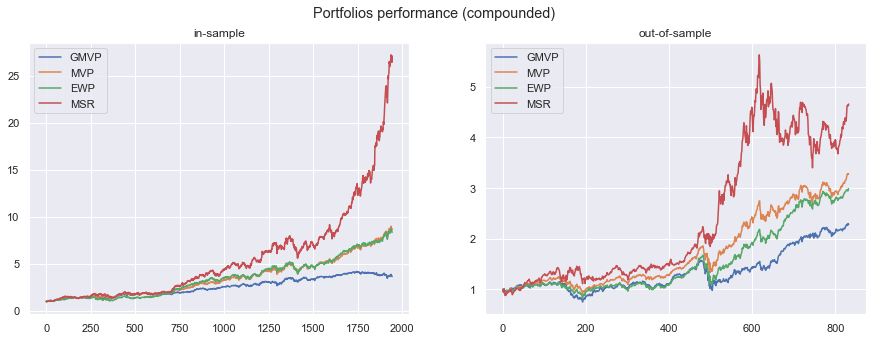

<Figure size 720x1080 with 0 Axes>

In [13]:
wealth_geom_trn = []
wealth_geom_tst = []
for i in range(4):
    wealth_geom_trn.append(np.cumprod(np.array(returns.iloc[:T_trn,]) @ (allocation.iloc[i,:].T)+1))
    wealth_geom_tst.append(np.cumprod(np.array(returns.iloc[T_trn:,]) @ (allocation.iloc[i,:].T)+1))  

# plots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
plt.figure(figsize=(10,15))
ax1.plot(np.array(wealth_geom_trn).T)
ax2.plot(np.array(wealth_geom_tst).T)
fig.suptitle('Portfolios performance (compounded)')
ax1.set_title("in-sample")
ax2.set_title("out-of-sample")
ax1.legend(allocation.index,loc = 2)
ax2.legend(allocation.index,loc = 2)
plt.show()

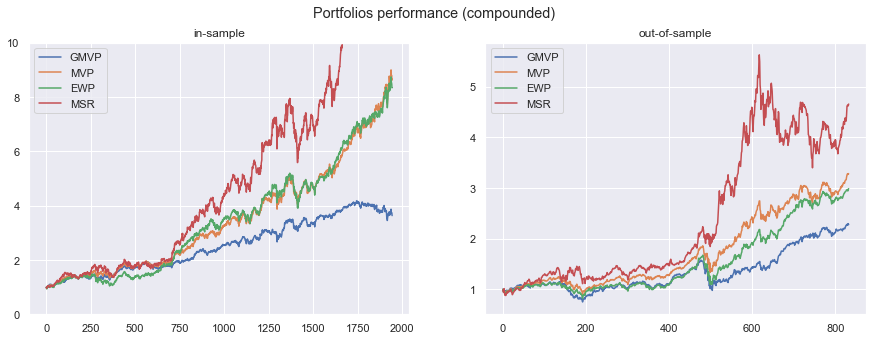

<Figure size 720x1080 with 0 Axes>

In [14]:

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
plt.figure(figsize=(10,15))
ax1.plot(np.array(wealth_geom_trn).T)
ax2.plot(np.array(wealth_geom_tst).T)
fig.suptitle('Portfolios performance (compounded)')
ax1.set_title("in-sample")
ax2.set_title("out-of-sample")
ax1.legend(allocation.index,loc = 2)
ax2.legend(allocation.index,loc = 2)
ax1.set(ylim=(0,10))
plt.show()


MSR:
As we can see that, the MSR allow short-selling the GE stocks, 
which results in significant return in train set
Although it shows the best performance in test set, we can see that the
the performance dropped dramatically for MSR portfolio
This portfolio is good for risk seekers, not risk adverse investors 

GMVP:
This portfolio shows consistency in both train and test dataset
As can be seen from the chart, GMVP show lowest volatility but also lowest returns
This portfolio is the safest bet for risk-adverse investors

MVP:
For this portfolio, we set the expected return to be equal to EWP portfolio.
Although we did include the short-selling option in building this portfolio,
the allocation doesn't have short position.
This portfolio shows higher return than GMVP still with a certain low volatility
In theory the MVP is risk-return optimal for risk-adverse investors.

EWP:
This portfolio is a naive way to build a portoflio.
It isn't belong to Mean-variance framework or Markowitz framework and doesn't optimize any criteria.
However, sometimes this portfolio yields good results, as in this case with this particular dataset of growing companies.
